<a href="https://colab.research.google.com/github/IndraniMandal/New-Revisions/blob/main/Bias_in_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias in Data
**Authors** John Biller, Indrani Mandal

In [ ]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it 
!test ! -e ds-assets && git clone https://github.com/IndraniMandal/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/" 
import sys
sys.path.append(home)
sys.path.append('../../')

Cloning into 'ds-assets'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 176 (delta 3), reused 2 (delta 0), pack-reused 164
Receiving objects: 100% (176/176), 9.35 MiB | 12.00 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
try:
    from google.colab import drive
    !pip install -q dtreeviz
    !pip install classification-confidence-interval
    !pip install shap 
    import sys
    
    
    drive.mount('/content/drive')
    notes_home = "/content/drive/My Drive/CSC 310/notes/"
    user_home = "/content/drive/My Drive/"
    
    sys.path.insert(1,notes_home) # let the notebook access the notes folder

except ModuleNotFoundError:
    notes_home = "" # running native Jupyter environment -- notes home is the same as the notebook
    user_home = ""  # under Jupyter we assume the user directory is the same as the notebook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement classification-confidence-interval (from versions: none)
ERROR: No matching distribution found for classification-confidence-interval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 4.6 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas 
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import warnings
import os
import scipy


np.set_printoptions(formatter={'float_kind':"{:3.2f}".format})
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from confint import classification_confint
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from treeviz import tree_print
import numpy as np
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression





# **Introduction**
The company seeks to automate (in real time) the loan qualifying procedure based on information given by customers while filling out an online application form. It is expected that the development of ML models that can help the company predict loan approval in accelerating decision-making process for determining whether an applicant is eligible for a loan or not.

# **Questions to Answer in Analysis:**
- “Does gender play a role in whether someone gets a loan?"
- "What are the main features that play a role in whether you get a loan?"



# **Prediction**
- I think gender will not play a role in loan status because that would mean the data set is biased.
- I think income, credit history, and loan amount will be the main features to get a loan. The other features are just characteristics of the applicants that should not hold a lot of weight.


#**Data**
The Loan data set is a data set that consists of 13 columns and 614 rows. In this data set each row represents the information of a given applicant. [Link to dataset](https://www.kaggle.com/datasets/burak3ergun/loan-data-set)

In [ ]:
# get data
df = pd.read_csv(notes_home+"Assets/loan_data.csv")


df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
df.shape

(614, 13)

## **Variables Used**
- There are 13 variables in the data set: 8 categorical, 4 continous, and 1 variable to accomodate the Loan ID

**Features**
- Loan_ID: Loan reference number
(unique ID)	LP001002; LP001003; ...
- Gender:	Applicant gender
(Male or Female)	Male; Female
- Married:	Applicant marital status
(Married or not married)	Married; Not Married
-Dependents:	Number of family members	0; 1; 2; 3+
- Education:	Applicant education/qualification
(graduate or not graduate)	Graduate; Under Graduate
- Self_Employed:	Applicant employment status
(yes for self-employed, no for employed/others)	Yes; No
- ApplicantIncome:	Applicant's monthly salary/income	5849; 4583; ...
- CoapplicantIncome:	Additional applicant's monthly salary/income	1508; 2358; ...
- LoanAmount:	Loan amount	128; 66; ...
- Loan_Amount_Term:	The loan's repayment period (in days)	360; 120; ...
- Credit_History:	Records of previous credit history
(0: bad credit history, 1: good credit history)	0; 1
- Property_Area:	The location of property
(Rural/Semiurban/Urban)	Rural; Semiurban; Urban

**Target**
- Loan_Status:	Status of loan
(Y: accepted, N: not accepted)	Y; N

# **Data Exploration**

# Categotical

It is important to explore the distrubution of categorical data to see if there are any impacts on the questions I am trying to answer.

In [ ]:
df.Gender.value_counts(dropna=False)

Male      489
Female    112
NaN        13
Name: Gender, dtype: int64

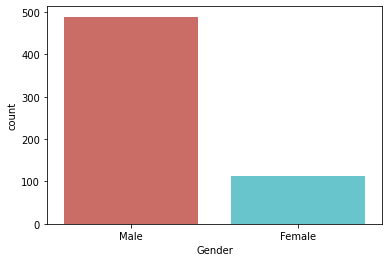

In [ ]:
sns.countplot(x="Gender", data=df, palette="hls")
plt.show()

**This shows the gender split of applicants in this study. There is 79% Males and 18% females, which is definitley disprotionate of applicants in the total population. This indicates that their can bias for males.**

In [ ]:
countMale = len(df[df.Gender == 'Male'])
countFemale = len(df[df.Gender == 'Female'])
countNull = len(df[df.Gender.isnull()])

print("Percentage of Male applicant: {:.2f}%".format((countMale / (len(df.Gender))*100)))
print("Percentage of Female applicant: {:.2f}%".format((countFemale / (len(df.Gender))*100)))
print("Missing values percentage: {:.2f}%".format((countNull / (len(df.Gender))*100)))

Percentage of Male applicant: 79.64%
Percentage of Female applicant: 18.24%
Missing values percentage: 2.12%


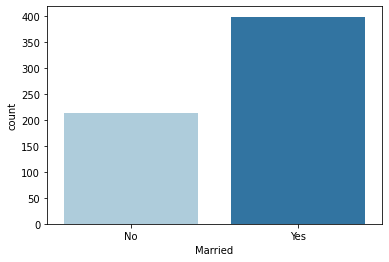

In [ ]:
sns.countplot(x="Married", data=df, palette="Paired")
plt.show()

In [ ]:
countMarried = len(df[df.Married == "Yes"])
countNotMarried = len(df[df.Married == "No"])
countNull = len(df[df.Married.isnull()])

print("Percentage of married: {:.2f}%".format((countMarried / (len(df.Married))*100)))
print("Percentage of Not married applicant: {:.2f}%".format((countNotMarried / (len(df.Married))*100)))
print("Missing values percentage: {:.2f}%".format((countNull / (len(df.Married))*100)))

Percentage of married: 64.82%
Percentage of Not married applicant: 34.69%
Missing values percentage: 0.49%


In [ ]:
df.Education.value_counts(dropna=False)

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [ ]:
df.Self_Employed.value_counts(dropna=False)

No     500
Yes     82
NaN     32
Name: Self_Employed, dtype: int64

In [ ]:
df.Credit_History.value_counts(dropna=False)

1.0    475
0.0     89
NaN     50
Name: Credit_History, dtype: int64

**Most cutomers have a good credit score, therefore I predict that the majority of applicants will have their loans accepted.** 

In [ ]:
df.Loan_Status.value_counts(dropna=False)

Y    422
N    192
Name: Loan_Status, dtype: int64

**Having a good credit and getting a loan accpeted have very similar counts therefore they are most likley correlated.**

In [ ]:
df.Property_Area.value_counts(dropna=False)

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

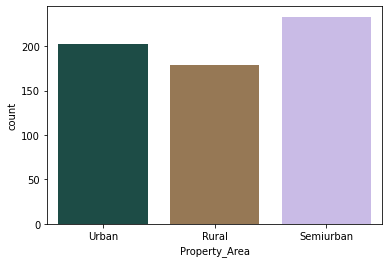

In [ ]:
sns.countplot(x="Property_Area", data=df, palette="cubehelix")
plt.show()

**Even distribution of location type of applicants**

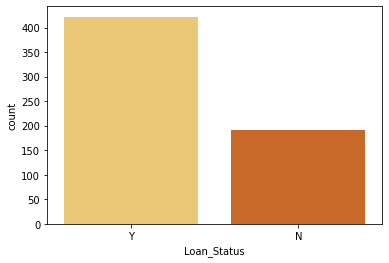

In [ ]:
sns.countplot(x="Loan_Status", data=df, palette="YlOrBr")
plt.show()

In [ ]:
countY = len(df[df.Loan_Status == 'Y'])
countN = len(df[df.Loan_Status == 'N'])
countNull = len(df[df.Loan_Status.isnull()])

print("Percentage of Approved: {:.2f}%".format((countY / (len(df.Loan_Status))*100)))
print("Percentage of Rejected: {:.2f}%".format((countN / (len(df.Loan_Status))*100)))
print("Missing values percentage: {:.2f}%".format((countNull / (len(df.Loan_Status))*100)))

Percentage of Approved: 68.73%
Percentage of Rejected: 31.27%
Missing values percentage: 0.00%


# Numerical 

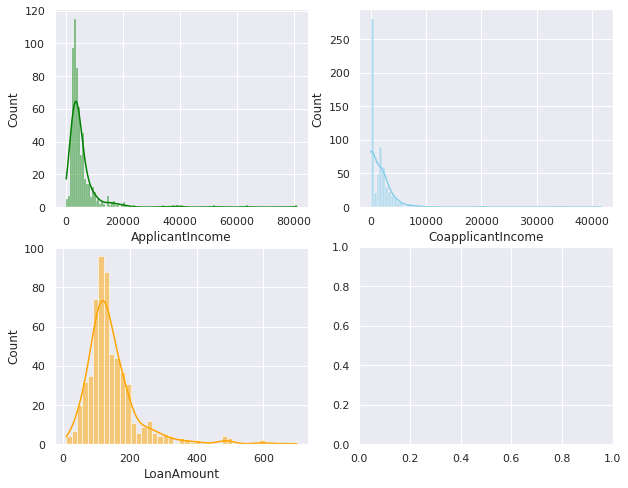

In [ ]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange');

**This shows the distribution of all three numerical features: Applicant income, Coapplicant income, and loan amount. They are all unimodel. The applicant/ co-applicant income is monthly salary.**

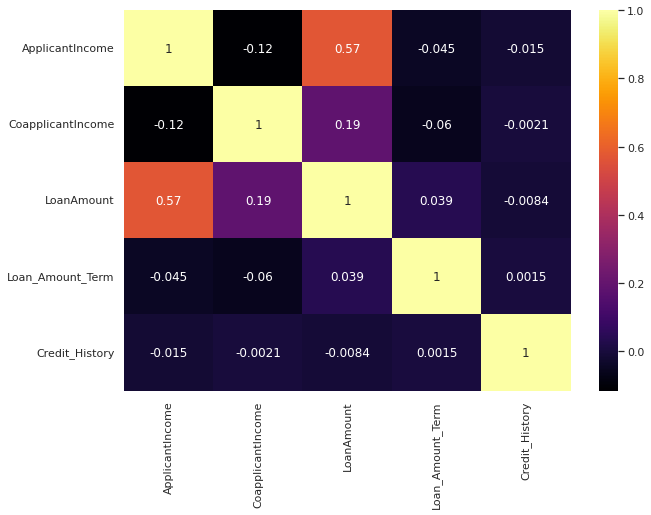

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap='inferno');

**There is a positive correlation between applicant income and loan amount. Suggesting that people with higher incomes have higher loan amounts. This makes sense because they have more money.**

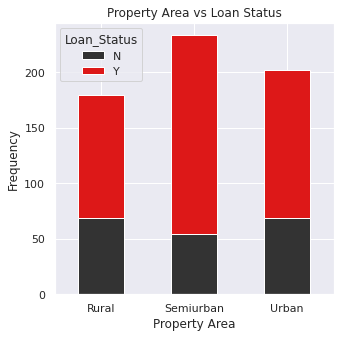

In [ ]:
pd.crosstab(df.Property_Area,df.Loan_Status).plot(kind="bar", stacked=True, figsize=(5,5), color=['#333333','#dd1818'])
plt.title('Property Area vs Loan Status')
plt.xlabel('Property Area')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

**This is a bar chart representing Property Area vs Loan Status. Rural applicants have the worst ratio according to loan status, followed by urban applicants. Semi Urban applicants have the highest number of applicants and the least amount declines in loan status. This suggests property loaction plays a role in loan status.**

# **Cleaning Dataset** - Data Preprocessing

In [ ]:
df = df.drop(['Loan_ID'],axis=1)

df['Gender'].replace([ "Female", "Male"], [0,1], inplace=True)
df['Married'].replace(["No", "Yes"], [0,1], inplace=True)
df['Self_Employed'].replace(["No", "Yes"], [0,1], inplace=True)
df['Education'].replace(["Not Graduate", "Graduate"], [0,1], inplace=True)
df['Property_Area'].replace(["Urban", "Semiurban", "Rural"], [1,2,3], inplace=True)
df['Dependents'].replace(["0", "1", "2", "3+"], [0,1,2,3], inplace=True)



df = df.dropna(how='any',axis=0)

**I dropped loan_id because it is has no impact on the study and by removing it, it removes all identity which is good because protection of data is important, especially with personal features.**

In [ ]:
features_df = pd.DataFrame(df)
features_df.head

<bound method NDFrame.head of      Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
1       1.0      1.0         1.0          1            0.0             4583   
2       1.0      1.0         0.0          1            1.0             3000   
3       1.0      1.0         0.0          0            0.0             2583   
4       1.0      0.0         0.0          1            0.0             6000   
5       1.0      1.0         2.0          1            1.0             5417   
..      ...      ...         ...        ...            ...              ...   
609     0.0      0.0         0.0          1            0.0             2900   
610     1.0      1.0         3.0          1            0.0             4106   
611     1.0      1.0         1.0          1            0.0             8072   
612     1.0      1.0         2.0          1            0.0             7583   
613     0.0      0.0         0.0          1            1.0             4583   

     CoapplicantIncom

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


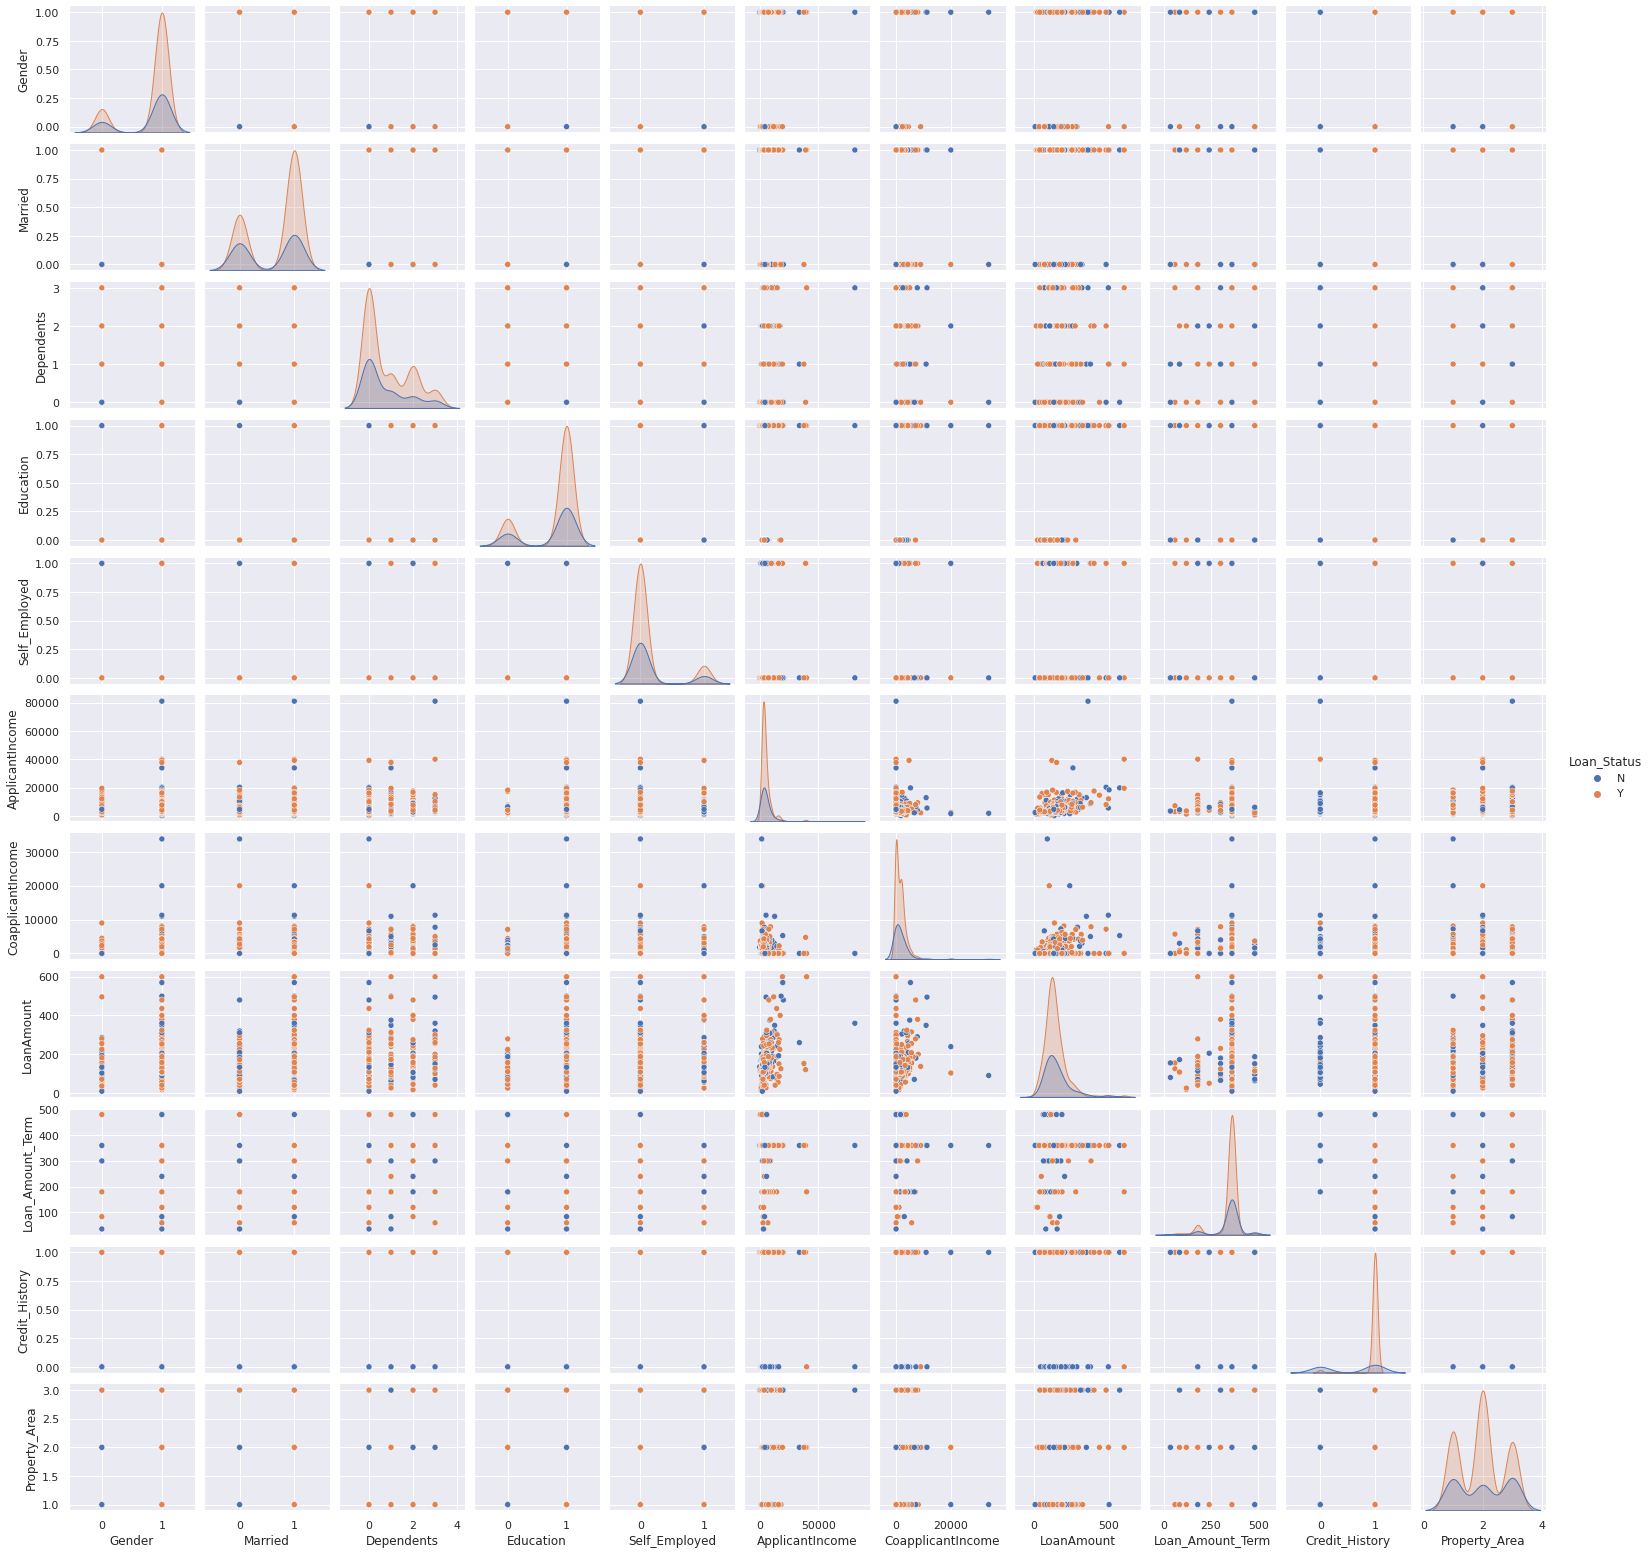

In [ ]:
sns.set()
sns.pairplot(features_df, hue= 'Loan_Status', size=2)

Important Highlights
- credit history
- property area
- education

###Split the Dataset into features and target
**The first step in model creation is to split the dataset into features and target. Each feature specifies a characteristic of the dataset. The target is the label attached to each observation(each row of data**).

In [ ]:
#seperate data

#Features
x = df.drop(['Loan_Status'],axis=1)
#Target
y = pd.DataFrame(df, columns=['Loan_Status'])

###Split the Dataset for training and testing

In [ ]:
#From the model selection library import the function for splitting the dataset into train and test sets
from sklearn.model_selection import train_test_split 

# Split the dataset (80% for train set and 20% in test set)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)


*   `X_train` - Training features used to fit(train) the model
*   `y_train` - Training target labels used to fit(train) the model
*   `X_test`  - Testing features used to test the model
*   `y_test`  - True target labels used to compare againest the model predicted labels


#Model metrics


In [ ]:
 #Import accuracy score and balanced accuracy score from model metrics package
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, balanced_accuracy_score

def model_metrics(y_true, y_predict):
  accuracy= accuracy_score(y_true, y_predict)
  precision=precision_score(y_true, y_predict, average='micro')
  recall=recall_score(y_true, y_predict, average='micro')
  f1=f1_score(y_true, y_predict, average='micro')
  balanced_accuracy=balanced_accuracy_score(y_true, y_predict)
  return [accuracy, precision, recall, f1, balanced_accuracy]

# **Model building and Comparison**


#Random Forest

In [ ]:
def balanced_accuracy_score(model, X_train, X_test, y_train): 
  from sklearn.metrics import balanced_accuracy_score
 
  model.fit(X_train, y_train)
  # Prediction using Testing data
  pred_test = model.predict(X_test)
  #calculate the balanced accuracy by comparing the true testing target and the predicted values
  return balanced_accuracy_score(y_test, pred_test)

In [ ]:
# import kFold and cross validation score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# do the 5-fold cross validation and shuffle the data
cv = KFold(n_splits=5,  shuffle = True)

rf = RandomForestClassifier(random_state=42)

scores = cross_val_score(rf, X_train, y_train,cv=cv)

print("Fold Accuracies: {}".format(scores))
rf_mean_score=scores.mean()
rf_balanced_acc= balanced_accuracy_score(rf, X_train, X_test, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

Fold Accuracies: [0.82 0.79 0.83 0.83 0.72]


<ipython-input-31-4c4bc5e71f4c>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [ ]:
rf_mean_score=scores.mean()
rf_mean_score

0.7992822966507178

In [ ]:
# we fit the model with the training data
rf.fit(X_train, y_train)

# Prediction using Training data
pred_train = rf.predict(X_train)
# Prediction using Testing data
pred_test = rf.predict(X_test)

#calculate the model metrics by comparing the true training target and the predicted values
rf_train_metrics= accuracy_score(y_train, pred_train)
#calculate the model metrics by comparing the true testing target and the predicted values
rf_test_metrics = accuracy_score(y_test, pred_test)

print(rf_train_metrics)
rf_test_metrics

<ipython-input-34-c1f9df503fe0>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


1.0


0.8125

**Random Forrest Model training and evaluation shows that based on the true testing data the model has an accuracy of 81%. However, there could be overfitting because the when predicting the training data it has 100% accuracy. This is a good model at predicting loan status based on the set of features because it has a high testing accuracy.**

# XG Boost

In [ ]:
import xgboost
# import kFold and cross validation score
from sklearn.model_selection import KFold, cross_val_score

# XGBClassifier
xgb = xgboost.XGBClassifier(random_state=42)

# do the 5-fold cross validation and shuffle the data
cv = KFold(n_splits=5,  shuffle = True)

scores = cross_val_score(xgb, X_train, y_train,cv=cv)

print("Fold Accuracies: {}".format(scores))
xgb_mean_score=scores.mean()
xgb_balanced_acc=balanced_accuracy_score(xgb, X_train, X_test, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Fold Accuracies: [0.75 0.73 0.78 0.81 0.76]


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

In [ ]:
import xgboost
# XGBClassifier
xgb = xgboost.XGBClassifier(cv=cv)

# we fit the model with the training data
xgb.fit(X_train, y_train)

# Prediction using Training data
pred_train = xgb.predict(X_train)
# Prediction using Testing data
pred_test = xgb.predict(X_test)

#calculate the model metrics by comparing the true training target and the predicted values
xgb_train_metrics= accuracy_score(y_train, pred_train)
#calculate the model metrics by comparing the true testing target and the predicted values
xgb_test_metrics = accuracy_score(y_test, pred_test)

print(xgb_train_metrics)
print(xgb_test_metrics)

0.8828125
0.8125


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**XG Boost Model training and evaluation shows that based on the true testing data the model has a testing accuracy of 81%. The training accuracy is 88% which is fine, considering the testing accuracy is very high.**

#Logistic Regregression

In [ ]:
# import kFold and cross validation score
from sklearn.model_selection import KFold, cross_val_score
#From the model selection library import logistic regression
from sklearn.linear_model import LogisticRegression

# do the 5-fold cross validation and shuffle the data
cv = KFold(n_splits=5,  shuffle = True)

#models is a logistic regression model
lr=LogisticRegression(random_state=0, max_iter=10000) #maximum iteration is set to a high value of 10,000

scores = cross_val_score(lr, X_train, y_train,cv=cv)

print("Fold Accuracies: {}".format(scores))
lr_mean_score=scores.mean()
lr_balanced_acc=balanced_accuracy_score(lr, X_train, X_test, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Fold Accuracies: [0.77 0.83 0.83 0.79 0.78]


In [ ]:
# LRClassifier
lr = xgboost.XGBClassifier(cv=cv)
# we fit the model with the training data
lr.fit(X_train, y_train)

# Prediction using Training data
pred_train = xgb.predict(X_train)
# Prediction using Testing data
pred_test = xgb.predict(X_test)

#calculate the model metrics by comparing the true training target and the predicted values
lr_train_metrics= accuracy_score(y_train, pred_train)
#calculate the model metrics by comparing the true testing target and the predicted values
lr_test_metrics = accuracy_score(y_test, pred_test)

print(lr_train_metrics)
print(lr_test_metrics)

0.8828125
0.8125


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Logistic Regression Model training and evaluation shows that the testing data in the model has a testing accuracy of 81%. The training accuracy is 88% which is fine, considering the testing accuracy is very high.**

# **Testing For Bias on Gender**

In [ ]:
df_male = df[df.Gender == 1]

In [ ]:
#seperate data

#Features
x_male= df_male.drop(['Loan_Status'],axis=1)
#Target
y_male= pd.DataFrame(df_male, columns=['Loan_Status'])

In [ ]:
#From the model selection library import the function for splitting the dataset into train and test sets
from sklearn.model_selection import train_test_split 

# Split the dataset (80% for train set and 20% in test set)
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(x_male, y_male, test_size=0.2, shuffle=True, random_state=42)

In [ ]:

# do the 5-fold cross validation and shuffle the data
cv_male = KFold(n_splits=5,  shuffle = True)

rf_male = RandomForestClassifier(random_state=42)

scores_male = cross_val_score(rf_male, X_train_male, y_train_male,cv=cv_male)

print("Fold Accuracies: {}".format(scores_male))
rf_mean_score_male=scores_male.mean()
rf_mean_score_male
#rf_balanced_acc_male=balanced_accuracy_score(rf_male, X_train_male, X_test_male, y_train_male)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

Fold Accuracies: [0.71 0.81 0.76 0.84 0.83]


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


0.7904761904761906

In [ ]:
#From the model selection library import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier will be used to build the model
rf_male= RandomForestClassifier(random_state=42)
# we fit the model with the training data
rf_male.fit(X_train_male, y_train_male)

# Prediction using Training data
pred_male = rf_male.predict(X_test_male)
# Prediction using Testing data
pred_general = rf_male.predict(X_test)

#calculate the model metrics by comparing the true training target and the predicted values
rf_male_metrics= accuracy_score(y_test_male, pred_male)
#calculate the model metrics by comparing the true testing target and the predicted values
rf_general_metrics = accuracy_score(y_test, pred_general)

print(rf_male_metrics) #male on male
rf_general_metrics #general pop is higher when removing females from the data set

<ipython-input-43-f4e44873ea08>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_male.fit(X_train_male, y_train_male)


0.8481012658227848


0.8958333333333334

**The code represents the analysis for the question: "Does Gender play a role in getting loans?" I used Random Forest Model because it had the highest CV and initial accuracy. The training data is all male data, filtering out females. By training only male data we can test this on the male testing data and also on the whole data set to see if there is bias against woman. What was interesting is that when testing male training data on the tested male data it yield a lower score than testing it on the overall testing data set including females.**

**This is quite significant because that means males have a higher accuracy in predicting loan status. Which means their is bias against woman. This can be due to the fact that males are over represented in this data. It also does not tell us if this has weight in the loan status. That will be answered in the next question.** 

# **Model Comparison**

In [ ]:
compare = pd.DataFrame({'Model': ['Logistic Regression','Random Forest', 'XG Boost'], 
                        'Accuracy': [lr_balanced_acc*100, rf_balanced_acc*100, xgb_balanced_acc*100]})
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
1,Random Forest,71.008403
2,XG Boost,71.008403
0,Logistic Regression,69.642857


**Based on balanced accuracy I am choosing the random forest model and XGB Boost to see which features impact loan status.**

# **XG Boost w Shap: What features Impact Loan Status?**

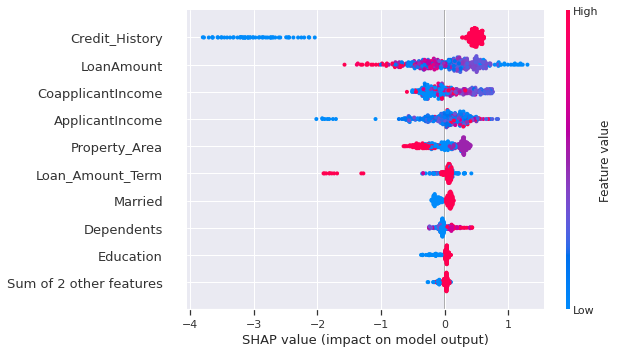

In [ ]:

import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)


**Most predictive features according to shap values are:**
- credit history
- loan amount
- coapplicant income
- applicant income *

It seems like these features are justified because they have to do with whether you have a good credit history, the size of the loan, and income of applicants. These are all extremley important features when deciding a loan. 

It is interesting seeing property area being 5th, this further suggests that location may provide biases when requesting a loan. 

# **Random Forest w Tree Model: What features Impact Loan Status?**

[Ellipsis]

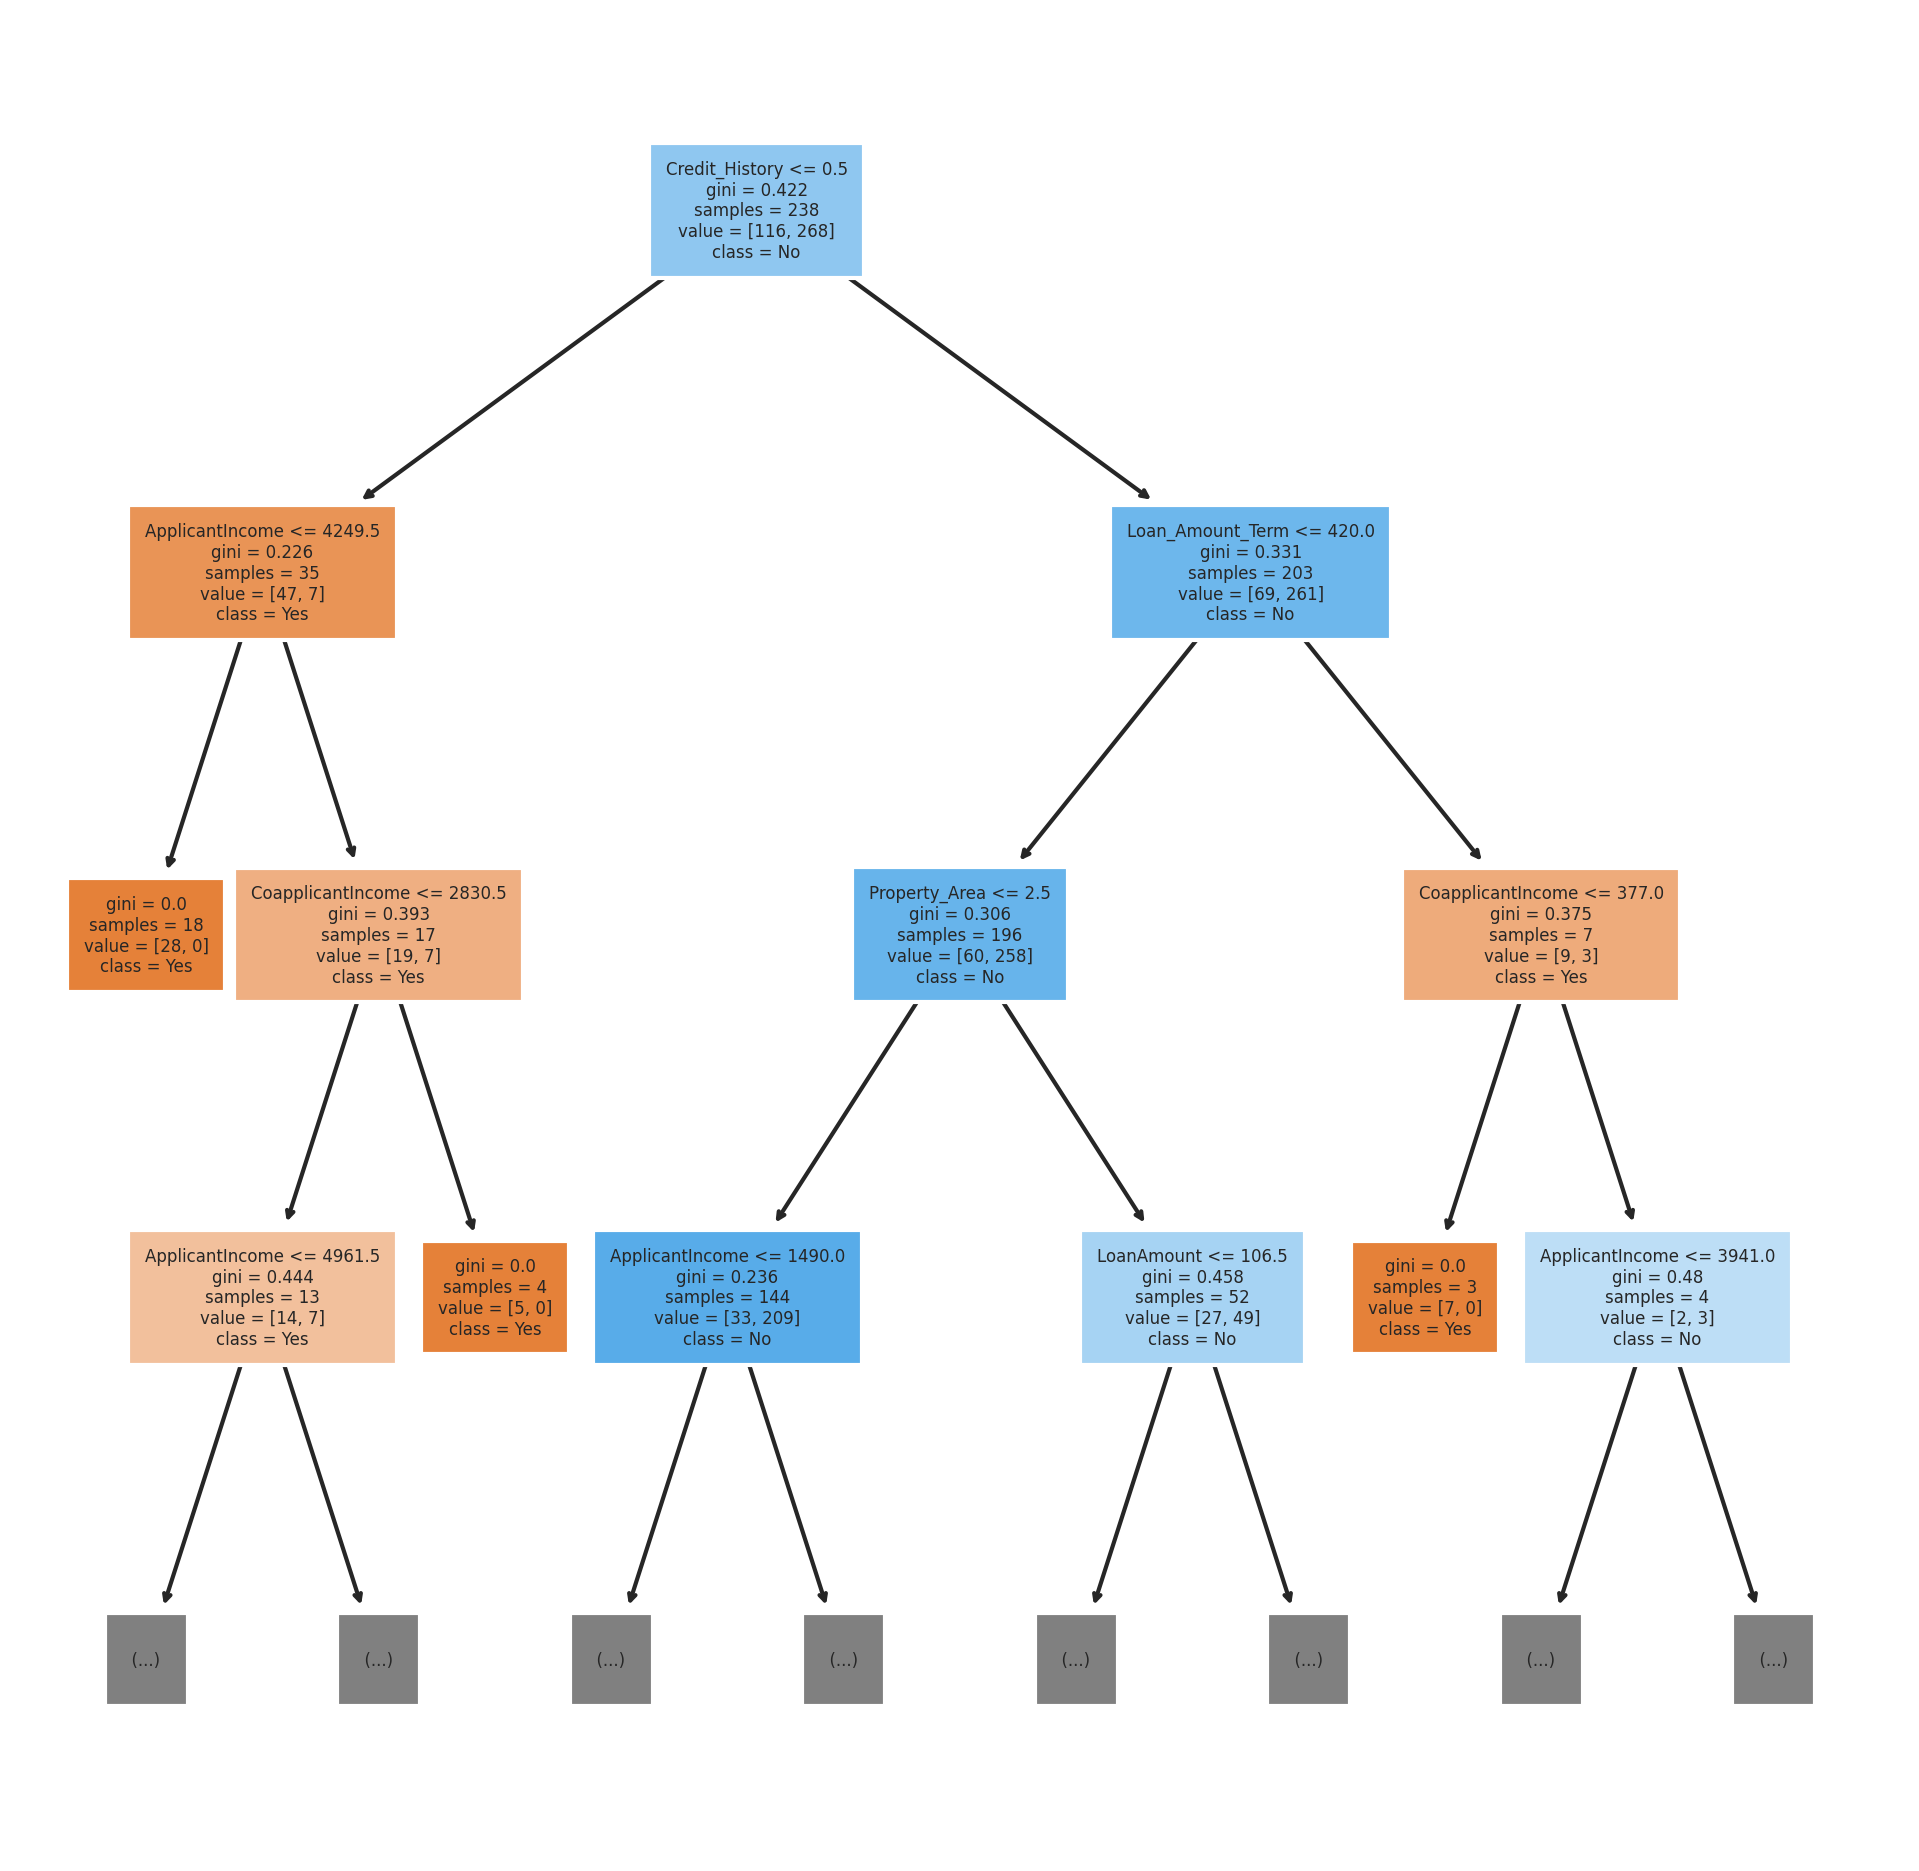

In [ ]:
# Visualize a tree model from random forest
import matplotlib.pyplot as plt  # visualization library
from sklearn.tree import plot_tree

fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
plot_tree(decision_tree = rf.estimators_[0], 
          fontsize=4, filled=True, 
          max_depth=3,
          feature_names=x.columns,
          class_names=['Yes', 'No'])
[...]

This is a a tree model using Random Forest. This further adds that the main features in determing the data set are:
- credit history
- loan amount
- applicant income
- co applicant income

It is interesting to see that if you have a bad credit history then applicants automatically can not get a loan.

### **Conclusion**


This data analysis helped answer important questions regarding loan status using different models shown above. It is important to look into these questions because we want to make sure that there is minimum bias/ discrimination to people applying for a loan status. 

- What are the main features in determining loan status?
This was helpful in determining the validity of the next two questions. Intuitively, the results made sense. The features with the greatest weight in determining loan status were attributes that have to do w credit, income, and amount. These are important when determining a loan and were expected in my predictions.

- Gender and its role in loan status?
It was its interesting in processing the data that much more men applied for loan status. The testing accuracy for training men is higher than the testing accuracy for training the original data set. This suggests bias, however we can see that gender does not hold a large weight in the decsion of a loan status. 

- Location of applicant on loan status?
There seems to be a correlation between loan status and location and there may be signifcance as can be seem in the tree model, shap, and bar chart. The sub urbs had a signifcantly accepted loan status then urban and rural applicants. Again, there are many underlining variables like the features that had more signicance listed above that can be assosiated with location.




This concludes my report